In [291]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

In [292]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
from scipy.interpolate import interp1d
import numpy as np
import json, pickle, shutil
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

base_path = os.path.abspath("..")  # pasta acima do notebook/script

dirs_to_add = ["Utils", "Optimization Problems", "DisturbedSaturatedPETC"]
for d in dirs_to_add:
    path = os.path.join(base_path, d)
    if path not in sys.path:
        sys.path.append(path)
        
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm
import DynamicSystem as ds
import DisturbedSaturatedPETC as DSPETC

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)
importlib.reload(ds)
importlib.reload(DSPETC)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16, 
        'tick_fontsize': 16,
    },
    'legend': { 'fontsize': 16 }
}

colors_list = plt.get_cmap('tab20').colors

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


### Definição da Planta

In [300]:
experiment_config_filename = 'experiment-1'

with open(f"experiment_configs/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

sim_duration = config['simulation_duration']
sim_step = config.get("simulation_step", 1e-4)
timepts = np.arange(0, sim_duration + sim_step, sim_step)

plant = ds.StateSpace(data=config["plant"], name='plant')
latex_string = plant.get_latex_equations()
print("Equações que regem a dinâmica da planta:")
display(Latex(latex_string))

Equações que regem a dinâmica da planta:


<IPython.core.display.Latex object>

### Simulação da Planta em Malha Aberta

In [294]:
ncs = ds.NetworkedControlSystem()
ncs.add_system(plant)

In [295]:
%%skip

ncs.setup_clock(duration=20.0, dt=1e-4)
ncs.reset_clock()

x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

while ncs.advance_clock():
  inputs = {'plant': {'u1': 0}}
  ncs.update_systems(inputs)

In [296]:
%%skip

# Plotagem dos resultados
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

y = ncs.output_history['plant']  # shape (ny, n_steps)
t = ncs.time_history

# Calcula norma ao longo das saídas
x_norm = np.linalg.norm(y, axis=0)  # shape (n_steps,)

# Formata para plot
xnorm_f, xnorm_ul, xnorm_dp = nm.format_magnitudes(x_norm,  n_divs=5)
t_f, t_ul, t_dp = nm.format_magnitudes(t, 's', use_prefixes=True, n_divs=5)
axis_limits = {'x_min': 0., 'x_max': t_f[-1]}

gph.plot(
    axs['x'], t_f, x_norm,
    xlabel='$t$' + t_ul,
    ylabel=r'$\|x(t)\|$',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'],
                       'x_digits': t_dp,
                       'y_digits': xnorm_dp},
              'limits': axis_limits,
              }
)

### Projeto do Controlador e do ETM

In [268]:
# --- Plant data structure ---
plant_data = {
    'nx': plant.nx, 'nu': plant.nu, 'nρ': plant.nρ, 'nw': plant.nw, 'nz': plant.nz,
    'ρ_bounds': plant.get_parameter_bounds(),
    'u_bar': plant.get_input_bounds()[0],
    'matrices_func': lambda ρi: plant.matrices_func(ρi),
}

# --- Design parameters ---
design_params = config["design_params"]["dspetc"]
# Flag for caching and saving results
should_save = design_params.get("save", True)

# --- Create a unique simulation identifier ---
try:
  simulation_id = ds.create_simulation_id(plant, design_params)
  print(f"Unique Simulation ID: {simulation_id}")
  results_dir = f"./results/{simulation_id}"
except (NameError, ValueError) as e:
  print(f"Error generating simulation ID: {e}")
  simulation_id = "sim_default"
  results_dir = "./results/sim_default"

# --- Cache file path ---
results_file_path = os.path.join(results_dir, "results_data.pkl")
results = None

try:
  if not should_save:
    # Execute solver without caching
    print("Save flag is False. Cache will be ignored.")
    results = DSPETC.detm_synthesis(plant_data, design_params)

  else:
    # Execute solver with caching
    print(f"Using cache file: {results_file_path}")

    if os.path.exists(results_file_path):
      # Attempt to load cache
      try:
        with open(results_file_path, 'rb') as f:
          results = pickle.load(f)
        print("Cache successfully loaded.")
      except Exception as e:
        print(f"Failed to load cache: {e}")
        results = None

    if results is None:
      # Run solver if cache does not exist or failed
      print("Running solver (fresh computation)...")
      results = DSPETC.detm_synthesis(plant_data, design_params)

      # Save results only if solver succeeds
      if results is not None:
        try:
          os.makedirs(results_dir, exist_ok=True)
          with open(results_file_path, 'wb') as f:
            pickle.dump(results, f)
          print("Results saved to cache.")
        except Exception as e:
          print(f"Failed to save results: {e}")

  # --- Process results ---
  Ξ = Ψ = K = L1 = P = γ = β = None
  Θ, λ = None, None
  optimal_value = None
  δinv = plant.get_disturbance_l2_norm_bound()

  if results is not None:
    Ξ, Ψ = results['etm']['Ξ'], results['etm']['Ψ']
    θ, λ = results['etm']['θ'], results['etm']['λ']
    K, L1, L2 = results['controller']['K'], results['controller']['L1'], results['controller']['L2']
    P, S2 = results['lyapunov']
    γ, β = results['bounds']
    optimal_value = results['optimal_value']

    # Display metrics and matrices
    print(
        f'θ = {θ:.3e}, λ = {λ:.3e}, γ = {γ:.3e}, Induced gain = {np.sqrt(1. / γ):.3e}')
    display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
    display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))
    display(Math(rf'P = {tex.mat2tex(P)}'))

    for i in nm.binary_set(plant.nρ):
      display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
      display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))

  else:
    print('Problem is infeasible or failed to load/compute results.')
    if should_save and os.path.exists(results_dir):
      shutil.rmtree(results_dir)
      print(f"Results directory removed: {results_dir}")

except Exception as e:
  print(f"Unexpected error during execution or processing: {e}")
  if should_save and os.path.exists(results_dir):
    try:
      shutil.rmtree(results_dir)
      print(f"Results directory removed after error: {results_dir}")
    except Exception as cleanup_e:
      print(f"Failed to remove results directory: {cleanup_e}")

Unique Simulation ID: sim_ea967a5b678af7698abcb259142d3ddd
Save flag is False. Cache will be ignored.
θ = 1.010e+00, λ = 1.000e-01, γ = 1.000e-01, Induced gain = 3.162e+00


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulação do Sistema em Malha Fechada

In [255]:
importlib.reload(ds)

sampler = ds.Sampler(Ts=design_params['h'])

In [256]:
importlib.reload(DSPETC)

detm = DSPETC.DETM(Ξ=Ξ, Ψ=Ψ, λ=λ, θ=θ)
ncs.add_system(detm)

In [257]:
ρ_bounds = plant_data['ρ_bounds']
u_bar = plant_data['u_bar']


controller = ds.GainScheduledController(K, ρ_bounds)

In [258]:
x0 = np.array([[-0.20346692], [0.33822176]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

detm.set_η0(0.0)
detm.x_hat = x0.copy()
detm.xm = x0.copy()

ncs.setup_clock(duration=20.0, dt=1e-4)
ncs.reset_clock()
sampler.reset()
event_time = []
uc = [[0.0]]
signal_control = []

while ncs.advance_clock():
  u_sat = sgn.sat(uc, u_bar)
  signal_control += [u_sat]
  default_inputs = {'plant': {'u1': u_sat}}
  with ncs.step(default_inputs=default_inputs) as step:
    # ---- Plant Side ----
    transmit = False
    if sampler.check(ncs.t):
      detm.xm = plant.states.copy()
      transmit = detm.triggering_condition() or (ncs.t == 0.0)

    # ---- Transmission Side ----
    if not transmit:
      continue
    ρ_hat = plant.evaluate_parameters(ncs.t)
    detm.x_hat = detm.xm.copy()
    event_time += [ncs.t]

    # ---- Controller Side ----
    uc = controller.compute(detm.x_hat, ρ_hat)

signal_control = np.squeeze(np.array(signal_control))
if signal_control.ndim == 1:
  signal_control = signal_control[np.newaxis, :]  # força (1, N)
else:
  signal_control = signal_control.T  # (nu, N)
event_time = np.array(event_time)
ncs.finalize_history()

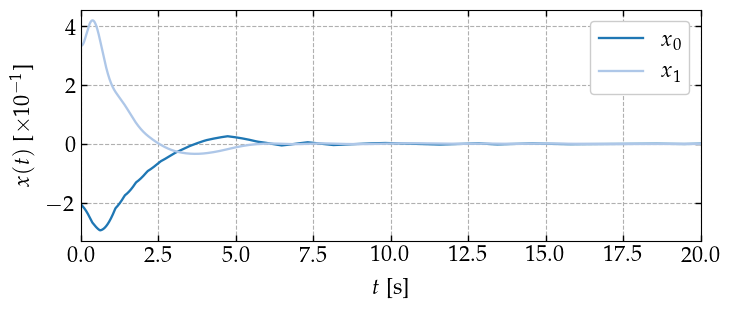

In [259]:
importlib.reload(gph)

mosaic = [['x']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 3))

y = ncs.output_history['plant']
t = ncs.time_history

fy = nm.format_magnitudes(y.flatten(), '', False, return_order=True)
scaled_y, y_label, y_order = fy

prev_fmt = (None, (scaled_y, y_label, y_order))

for i in range(plant.nx):
  cor_atual = colors_list[i]
  _ = gph.plot(axs['x'], t, y[i], xlabel='$t$', x_unit='s', x_use_prefixes=True,
               ylabel=r'$x(t)$', label=f'$x_{i}$', prev_format=prev_fmt,
               cfg={**cfg, 'style': {'color': cor_atual}},
               x_pad=(0.0, 0.0), y_pad=(0.05, 0.05))

In [260]:
if len(event_time) == 0:
  inter_event_time = np.array([])
else:
  inter_event_time = np.empty_like(event_time)
  inter_event_time[0] = event_time[0]
  inter_event_time[1:] = event_time[1:] - event_time[:-1]

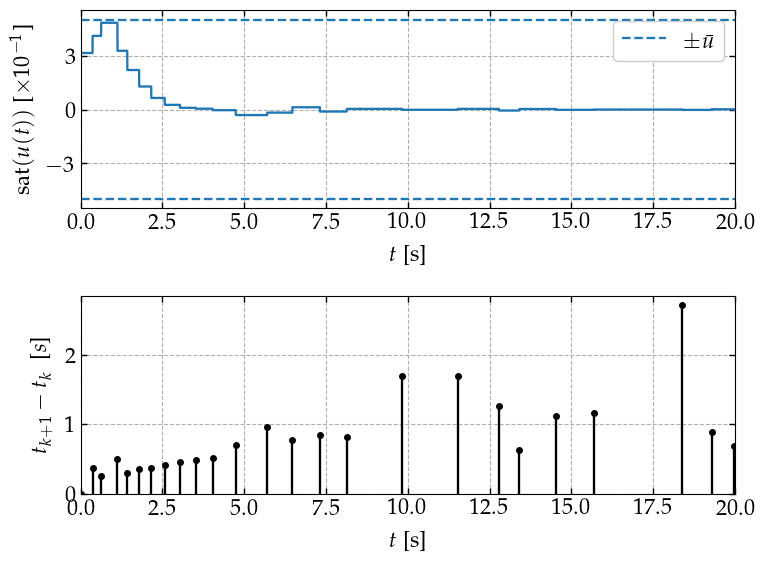

In [261]:
importlib.reload(nm)
importlib.reload(gph)

mosaic = [['control'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

for i in range(plant.nu):
  _, fmt = gph.plot(axs['control'], t, signal_control[i], xlabel='$t$', x_unit='s',
                    x_use_prefixes=True, ylabel=r'sat$(u(t))$',
                    cfg={**cfg, 'style': {'color': colors_list[i]}})

  gph.plot(axs['control'], [0, t[-1]], [u_bar[i]] * 2, prev_format=fmt,
           cfg={**cfg, 'style': {**cfg['style'], 'linestyle': '--', 'color': colors_list[i]}})

  gph.plot(axs['control'], [0, t[-1]], [-u_bar[i]] * 2, prev_format=fmt, label=r'$\pm \bar u$',
           y_pad=(0.05, 0.075),
           cfg={**cfg, 'style': {**cfg['style'], 'linestyle': '--', 'color': colors_list[i]}})


gph.stem(
    axs['iet'], event_time, inter_event_time,
    reuse_previous=False, y_pad=(0.0, 0.05), x_use_prefixes=True,
    xlabel='$t$', x_unit='s', x_range=(0.0, t[-1]),
    ylabel='$t_{k+1} - t_k\\;$ [$s$]',
    cfg={**cfg, 'limits': {'x_min': 0, 'x_max': t[-1]}, }
)

plt.tight_layout(pad=2.)